# Programming Assignment 4: Sentiment analysis with SVM

In this programming assignment, we will revisit the problem of sensiment analysis, but using a different approach. Recall that the task is to predict the *sentiment* (positive or negative) of a single sentence taken from a review of a movie, restaurant, or product. The data set consists of 3000 labeled sentences, which we divide into a training set of size 2500 and a test set of size 500. Previously we found a logistic regression classifier. Today we will use a support vector machine.

Make sure the notebook is in the same folder that contains `full_set.txt`.

## 1. Load and preprocess data

In [87]:
%matplotlib inline
import string
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)

The data set consists of 3000 sentences, each labeled '1' (if it came from a positive review) or '0' (if it came from a negative review). To be consistent with our notation from lecture, we will change the negative review label to '-1'.

In [88]:
## Read in the data set.
with open("full_set.txt") as f:
    content = f.readlines()
    
## Remove leading and trailing white space
content = [x.strip() for x in content]

## Separate the sentences from the labels
sentences = [x.split("\t")[0] for x in content]
labels = [x.split("\t")[1] for x in content]

## Transform the labels from '0 v.s. 1' to '-1 v.s. 1'
y = np.array(labels, dtype='int8')
y = 2*y - 1

### Preprocessing the text data

To transform this prediction problem into one amenable to linear classification, we will first need to preprocess the text data. We will do four transformations:

1. Remove punctuation and numbers.
2. Transform all words to lower-case.
3. Remove _stop words_.
4. Convert the sentences into vectors, using a bag-of-words representation.

We begin with first two steps.

In [89]:
## full_remove takes a string x and a list of characters removal_list 
## returns x with all the characters in removal_list replaced by ' '
def full_remove(x, removal_list):
    for w in removal_list:
        x = x.replace(w, ' ')
    return x

## Remove digits
digits = [str(x) for x in range(10)]
digit_less = [full_remove(x, digits) for x in sentences]

## Remove punctuation
punc_less = [full_remove(x, list(string.punctuation)) for x in digit_less]

## Make everything lower-case
sents_lower = [x.lower() for x in punc_less]

### Stop words

Stop words are words that are filtered out because they are believed to contain no useful information for the task at hand. These usually include articles such as 'a' and 'the', pronouns such as 'i' and 'they', and prepositions such 'to' and 'from'. We have put together a very small list of stop words, but these are by no means comprehensive. Feel free to use something different; for instance, larger lists can easily be found on the web.

In [90]:
## Define our stop words
stop_set = set(['the', 'a', 'an', 'i', 'he', 'she', 'they', 'to', 'of', 'it', 'from'])

## Remove stop words
sents_split = [x.split() for x in sents_lower]
sents_processed = [" ".join(list(filter(lambda a: a not in stop_set, x))) for x in sents_split]

### Bag of words

In order to use linear classifiers on our data set, we need to transform our textual data into numeric data. The classical way to do this is known as the _bag of words_ representation. In this representation, each word is thought of as corresponding to a number in `{1, 2, ..., d}` where `d` is the size of our vocabulary. And each sentence is represented as a d-dimensional vector $x$, where $x_i$ is the number of times that word $i$ occurs in the sentence.

To do this transformation, we will make use of the `CountVectorizer` class in `scikit-learn` (Note that this is the only time you can call an external function from scikit-learn). We will cap the number of features at 4500, meaning a word will make it into our vocabulary only if it is one of the 4500 most common words in the corpus. This is often a useful step as it can weed out spelling mistakes and words which occur too infrequently to be useful.

Once we get the bag-of-words representation, append a '1' to the beginning of each vector to allow our linear classifier to learn a bias term.

In [91]:
from sklearn.feature_extraction.text import CountVectorizer

## Transform to bag of words representation.
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None, max_features = 4500)
data_features = vectorizer.fit_transform(sents_processed)
data_mat = data_features.toarray()
print ('The original size: ',data_features.shape)

The original size:  (3000, 4500)


### Training / test split

Finally, we split the data into a training set of 2500 sentences and a test set of 500 sentences (of which 250 are positive and 250 negative).

In [92]:
## Split the data into testing and training sets
np.random.seed(0)
test_inds = np.append(np.random.choice((np.where(y==-1))[0], 250, replace=False), np.random.choice((np.where(y==1))[0], 250, replace=False))
train_inds = list(set(range(len(labels))) - set(test_inds))

train_data = data_mat[train_inds,]
train_labels = y[train_inds]

test_data = data_mat[test_inds,]
test_labels = y[test_inds]

print("train data: ", train_data.shape)
print("test data: ", test_data.shape)

train data:  (2500, 4500)
test data:  (500, 4500)


## 2. Solving for soft-margin SVM


Recall that support vector machine (SVM) finds a linear decision boundary with the largest margin for a binary classification problem. Suppose we have a training dataset $\{(x_{1},y_1),...,(x_n,y_n)\}$
where $x_{i} \in \mathbb{R}^{d}$ are feature vectors and $y_i\in\{-1,+1\}$ are labels.  The linear classifier is parametrized by $\theta\in \mathbb{R}^{d}$ and $\theta_0\in\mathbb{R}$, and predicts +1 at a point $x$ if $\theta\cdot x+\theta_0>0$ and -1 otherwise. 

It turns out that the soft-margin SVM optimization is equivalent to the following unconstrained optimization:
$$\underset{\theta\in\mathbb{R}^d,\theta\in\mathbb{R}}{\text{min}}\|\theta\|^2+C\sum_{i=1}^n\ell_{\mathrm{hinge}}(y_i(\theta\cdot x_i+\theta_0))$$
where  $\ell_{\mathrm{hinge}}(t)=\max(0,1-t)$ is called the ``hinge loss,'' which takes value $1-t$ if $t<1$ and 0 otherwise. For example, $\ell_{\mathrm{hinge}}(-1)=2$, and $\ell_{\mathrm{hinge}}(2)=0$. 


It turns out that for gradient-based optimization, hinge loss may be difficult to deal with because it is not differentiable at point $t=1$. One solution is to use the ``smoothed version'' of hinge loss:

$$\ell_{\mathrm{smooth-hinge}}(t) = \begin{cases}
\frac{1}{2} - t      & \text{if} ~~ t \le 0, \\
\frac{1}{2} (1 - t)^2 & \text{if} ~~ 0 < t < 1, \\
0                      & \text{if} ~~ 1 \le t
\end{cases}$$


Thus, in the rest of the problem, we will consider the following optimization:
$$\underset{\theta\in\mathbb{R}^d,\theta\in\mathbb{R}}{\text{min}}\|\theta\|^2+C\sum_{i=1}^n\ell_{\mathrm{smooth-hinge}}(y_i(\theta\cdot x_i+\theta_0))$$

**Task P2:** Implement the hinge loss function and the smooth hinge loss function. Plot the function $\ell_{\mathrm{hinge}}(t)$ and $\ell_{\mathrm{smooth-hinge}}(t)$for $t\in[-5,5]$.

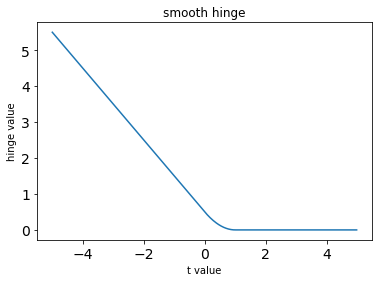

In [93]:
### STUDENT: Start of code ###
def hinge_loss_smooth(t):
       
    if (t<=0):
        return ((1/2)-t)
    elif(t>0 and t<1):
        return (1/2)*(pow((1-t),2))
    else:
        return (0)

def hinge_loss(t):
    
    if (t<1):
        return (1-t)
    else :
        return (0)
        
x = []
sh = [0]*500
h = [0]*500
for i in range(500):
    t = (i-250)/50
    x.append(t)
    sh[i]=(hinge_loss_smooth(t))
    h[i]=(hinge_loss(t))
    
    
        
plt.plot(x,sh)
plt.title('smooth hinge')
plt.ylabel('hinge value')
plt.xlabel('t value')
plt.show()


plt.plot(x,h)
plt.title('hinge')
plt.ylabel('hinge value')
plt.xlabel('t value')
plt.show()


### End of code ###

**Task P5:** Let $f(\theta,\theta_0)= \|\theta\|^2+C\sum_{i=1}^n\ell_{\mathrm{smooth-hinge}}(y_i(\theta\cdot x_i+\theta_0))$ be the objective function of the optimization problem we want to solve. Implement the function that obtains the partial derivative $\frac{\partial }{\partial \theta}f(\theta,\theta_0)$ and $\frac{\partial }{\partial \theta_0}f(\theta,\theta_0)$. Also, print out the output of the code that calculates the derivatives at $\theta=1$ and $\theta_0=1$ with $C=1$.

Hint: you need to calculate the partial derivative of the smoothed hinge loss for each data point separately, and add them together to obtain the result.

In [234]:

def weight_derivative(theta, theta0, C, feature_matrix, labels):
    # Input:
    # theta: weight vector theta, a numpy vector of dimension d
    # theta0: intercept theta0, a numpy vector of dimension 1
    # C: constant C
    # feature_matrix: numpy array of size n by d, where n is the number of data points, and d is the feature dimension
    # labels: true labels y, a numpy vector of dimension d, each with value -1 or +1
    # Output:
    # Derivative of the cost function with respect to the weight theta, grad_theta
    # Derivative of the cost function with respect to the weight theta0, grad_theta0
    
    
    ## STUDENT: Start of code ###
    score_matrix = (feature_matrix.dot(theta) + theta0)  * labels
    
    feature_matrix1=np.array([np.zeros(4500)]*2500)
    feature_matrix2=np.array([np.zeros(4500)]*2500)
    
    for i in range(len(score_matrix)):
        if score_matrix[i]<=0:
            feature_matrix1[i] = feature_matrix[i]
        elif score_matrix[i]<1:
            feature_matrix2[i] = feature_matrix[i]
    
    
    grad_theta =  2*theta-C*((feature_matrix1).T).dot(labels)-C*((feature_matrix2).T).dot(labels*(1-(feature_matrix2.dot(theta)+theta0)*labels))
    grad_theta0 = np.sum(-C*((feature_matrix1).T).dot(labels)-C*((feature_matrix2).T).dot(labels*(1-(feature_matrix2.dot(theta)+theta0)*labels)))
    
    
    return grad_theta, grad_theta0
    # End of code ###

In [235]:
# STUDENT: PRINT THE OUTPUT AND COPY IT TO THE SOLUTION FILE
theta = np.ones(data_mat.shape[1]) # a weight of all 1s

theta0 = np.ones(1) # a number 1
C = 0.05
grad_theta, grad_theta0 = weight_derivative(theta, theta0, C,train_data,train_labels)

print (grad_theta[:10])
print (grad_theta0)


[2.   2.05 2.05 2.1  2.05 2.05 3.8  2.15 2.   2.  ]
592.5500000000001


**Task P6:**  For sentiment analysis data, choose a value for the trade-off parameter $C$. Report the training error at convergence and the testing error. 

Note:  you can just use the same gradient descent algorithm that we wrote in assignment 2, or use the adam_optimizer provided below.

Here is an [article](https://towardsdatascience.com/adam-latest-trends-in-deep-learning-optimization-6be9a291375c#:~:text=Adam%20%5B1%5D%20is%20an%20adaptive,for%20training%20deep%20neural%20networks.&text=The%20algorithms%20leverages%20the,learning%20rates%20for%20each%20parameter) on the Adam optimizer.

In [236]:
def objective(feature_matrix, labels, theta,theta0, C):
    score = (feature_matrix.dot(theta)+theta0)*labels
    return np.sum(theta**2)+C*np.sum([hinge_loss_smooth(t) for t in score])

In [237]:
def adam_optimizer(feature_matrix, labels, initial_theta,initial_theta0, C, step_size=0.01, tolerence=0.01, b1=0.9, b2=0.999, eps=10**-8):
    # Gradient descent algorithm for logistic regression problem    
    
    # Input:
    # feature_matrix: numpy array of size n by d, where n is the number of data points, and d is the feature dimension
    # labels: true labels y, a numpy vector of dimension d
    # initial_theta: initial theta to start with, a numpy vector of dimension d
    # initial_theta0: initial theta0 to start with, a numpy vector of dimension 1
    # step_size: step size of update
    # tolerance: tolerace epsilon for stopping condition
    # Parameters by Adam optimizer
    # Output:
    # Weights obtained after convergence

    converged = False 
    m = np.zeros(len(initial_theta))
    v = np.zeros(len(initial_theta))
    m0 = np.zeros(1)
    v0 = np.zeros(1)
    theta = np.array(initial_theta) # current iterate
    theta0 = np.array(initial_theta0) # current iterate
    i = 0
    while not converged:
        # impelementation of what the gradient descent algorithm does in every iteration
        # Refer back to the update rule listed above: update the weight
        i += 1
        grad_theta, grad_theta0  = weight_derivative(theta, theta0, C,feature_matrix, labels)
        
        m = (1 - b1) * grad_theta      + b1 * m  # First  moment estimate.
        v = (1 - b2) * (grad_theta**2) + b2 * v  # Second moment estimate.
        mhat = m / (1 - b1**(i + 1))    # Bias correction.
        vhat = v / (1 - b2**(i + 1))
        theta = theta - step_size*mhat/(np.sqrt(vhat) + eps)
        
        m0 = (1 - b1) * grad_theta0      + b1 * m0  # First  moment estimate.
        v0 = (1 - b2) * (grad_theta0**2) + b2 * v0  # Second moment estimate.
        mhat0 = m0 / (1 - b1**(i + 1))    # Bias correction.
        vhat0 = v0 / (1 - b2**(i + 1))
        theta0 = theta0 - step_size*mhat0/(np.sqrt(vhat0) + eps)
        
        # Compute the gradient magnitude:
        
        gradient_magnitude = np.sqrt(np.sum(grad_theta**2))
        
        # Check the stopping condition to decide whether you want to stop the iterations
        
        if gradient_magnitude < tolerance:
            converged = True
        
        preds_train = model_predict(train_data,theta,theta0)

        ## Compute errors
        errs_train = np.sum((preds_train > 0.0) != (train_labels > 0.0))

        print ("Iteration: ",i,"objective: ",objective(feature_matrix, labels, theta,theta0, C),"tr err: ",float(errs_train)/len(train_labels),"gradient_magnitude: ", gradient_magnitude) # for us to check about convergence
        
    return(theta, theta0)

### End of code ###

In [238]:
def model_predict(feature_matrix,theta,theta0):
# Prediction made by SVM 
    
    # Input:
    # feature_matrix: numpy array of size n by d+1, where n is the number of data points, and d+1 is the feature dimension
    #                 note we have included the dummy feature as the first column of the feature_matrix
    # theta: weight theta, a numpy vector of dimension d
    # theta0: weight theta0, a numpy vector of dimension 1
    # Output:
    # labels: predicted labels, a numpy vector of dimension n
    
    h =  feature_matrix.dot(theta)+theta0
    y_h = (h >= 0)*2-1
    
    return y_h    

In [240]:
# Initialize the weights, step size and tolerance
# Start of code
initial_theta = np.ones(data_mat.shape[1]) ## STUDENT: initialize theta
initial_theta0 = 1   ## STUDENT: initialize theta0
C =  0.05## STUDENT: choose the C
step_size =  0.25## STUDENT: choose the step_size
tolerance =  0.5## STUDENT: choose the tolerance

# end of code

theta, theta0 = adam_optimizer(train_data,train_labels, initial_theta, initial_theta0,C, step_size, tolerance)
print (theta)
print (theta0)

Iteration:  1 objective:  3545.8714464948744 tr err:  0.5 gradient_magnitude:  148.83325401267018
Iteration:  2 objective:  2052.5568458443495 tr err:  0.5 gradient_magnitude:  125.04449174476329
Iteration:  3 objective:  934.3252932696332 tr err:  0.5 gradient_magnitude:  98.5722843426276
Iteration:  4 objective:  256.09063627418703 tr err:  0.5 gradient_magnitude:  72.80225599298012
Iteration:  5 objective:  85.64742233832362 tr err:  0.5 gradient_magnitude:  50.409180875802804
Iteration:  6 objective:  364.58463728416405 tr err:  0.5 gradient_magnitude:  43.11330879348488
Iteration:  7 objective:  738.2636823797842 tr err:  0.5 gradient_magnitude:  59.49314134548522
Iteration:  8 objective:  1048.2033921231662 tr err:  0.5 gradient_magnitude:  70.8959519767518
Iteration:  9 objective:  1201.943076255052 tr err:  0.4984 gradient_magnitude:  79.13288651598073
Iteration:  10 objective:  1178.435816766389 tr err:  0.488 gradient_magnitude:  82.96007933976281
Iteration:  11 objective:  1

Iteration:  83 objective:  40.80098352064481 tr err:  0.118 gradient_magnitude:  8.649402118053562
Iteration:  84 objective:  40.69682944617618 tr err:  0.1088 gradient_magnitude:  4.09710422082233
Iteration:  85 objective:  40.91895535458079 tr err:  0.1136 gradient_magnitude:  2.7612425939718626
Iteration:  86 objective:  40.85670460072058 tr err:  0.1132 gradient_magnitude:  6.77282016245831
Iteration:  87 objective:  40.52139456189409 tr err:  0.1108 gradient_magnitude:  6.904863809713082
Iteration:  88 objective:  40.44882666030369 tr err:  0.1132 gradient_magnitude:  3.3387480225632045
Iteration:  89 objective:  40.66283479792442 tr err:  0.1204 gradient_magnitude:  2.0475373283355554
Iteration:  90 objective:  40.70940665938226 tr err:  0.1204 gradient_magnitude:  5.660712111415757
Iteration:  91 objective:  40.53575051019004 tr err:  0.11 gradient_magnitude:  5.887304385483076
Iteration:  92 objective:  40.48889739510529 tr err:  0.108 gradient_magnitude:  2.917119368550896
Ite

In [245]:
# STUDENT: copy the output of this section to the solution file

## Get predictions on training and test data
preds_train = model_predict(train_data,theta,theta0)
preds_test = model_predict(test_data,theta,theta0)


## Compute errors



print ("Training error: ", float(errs_train)/len(train_labels))
print ("Test error: ", float(errs_test)/len(test_labels))



Training error:  0.1048
Test error:  0.188


**Task P7:**  List 4 example sentences that are correctly classified by SVM, and 4 example sentences that are  incorrectly classified by SVM. Explain what you have found.

In [242]:
# STUDENT: your code here
## number of sentaneces found that meet criteria
good_found =0
bad_found =0

good_sentance = []
bad_sentance = []
for i in range(len(preds_train)):
    if((preds_train[i] > 0.0) and (train_labels[i] < 0.0)):
        if (bad_found<4):
            bad_found+=1
            bad_sentance.append(sentences[i])
    elif((preds_train[i] < 0.0) and (train_labels[i] > 0.0)):
        if (bad_found<4):
            bad_found+=1
            bad_sentance.append(sentences[i])
    else:
        if (good_found<4):
            good_found+=1
            good_sentance.append(sentences[i])
    if good_found>=4 and bad_found>=4:
        break
           
print('Correctly identified  sentances')
for sentance in good_sentance:
    print(sentance)
print(' ')
print('Incorrectly identified sentances')
for sentance in bad_sentance:
    print(sentance)
            

Correctly identified  sentances
So there is no way for me to plug it in here in the US unless I go by a converter.
Good case, Excellent value.
Great for the jawbone.
Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!
 
Incorrectly identified sentances
If you are Razr owner...you must have this!
You need at least 3 mins to get to your phone book from the time you first turn on the phone.Battery life is short.
A week later after I activated it, it suddenly died.
Even in my BMW 3 series which is fairly quiet, I have trouble hearing what the other person is saying.
